# xAutoML Project 1
---

# **Project description**

**Step 1:**

Dataset: Heart.csv

Algorithms:

*   Logistic regression
*   Decision Tree Classifier
*   SVC
*   KNeighborsClassifier
*   GaussianNB
*   MLPClassifier
*   LinearDiscriminantAnalysis
*   VotingClassifier
*   BaggingClassifier
*   ExtraTreesClassifier
*   AdaBoostClassifier
*   GradientBoostingClassifier
*   RandomForestClassifier

Results:

Random Forest Accuracy = 0.9854

**Step 2:**

Use HyperOPT with potential search space to beat baseline



**Step 3:**

Measuring Performance accross different time budget

Results:

**Step 4:**

Checking if the difference is statistical different or not


## **Load and Preprocess the Dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("heart.csv")
print(df.head())

# Separate features and target
X = df.drop(columns=["target"])  # 'target' is the label column
y = df["target"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


## **Training baseline models with default parameters**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings


In [ ]:
def test_baseline_models():
    # List of 13 baseline models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "SVM": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Gaussian Naive Bayes": GaussianNB(),
        "Extra Trees": ExtraTreesClassifier(),
        "Bagging": BaggingClassifier(),
        "Voting": VotingClassifier(estimators=[
            ('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('svc', SVC(probability=True))], voting='soft'),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "MLP Classifier": MLPClassifier()
    }

    # Train and evaluate each model
    best_model = None
    best_accuracy = 0
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      for name, clf in models.items():
          clf.fit(X_train, y_train)
          y_pred = clf.predict(X_test)
          accuracy = accuracy_score(y_test, y_pred)
          #print(f"{name}: Accuracy = {accuracy:.4f}")
          if accuracy > best_accuracy:
              best_accuracy = accuracy
              best_model = clf

    return best_model, best_accuracy

In [ ]:
number_of_tests = 10
best_models = []
best_baseline_accuracies = []

for t in range(number_of_tests):
    print(f"Test {t+1}:")
    best_model, best_accuracy = test_baseline_models()
    print(f"Best model for test {t}: {best_model}")
    print(f"Best accuracy for test {t}: {best_accuracy}")

    best_models.append(best_model)
    best_baseline_accuracies.append(best_accuracy)

print("")
print("=" * 80)
print("=========== Final Results of baseline model tests =============")
print(f"Best models for each test: {best_models}")
print(f"Best accuracies for each test: {best_baseline_accuracies}")
print("Average best accuracy:", sum(best_baseline_accuracies) / len(best_baseline_accuracies))
print("=" * 80)

Test 1:
Best model for test 0: DecisionTreeClassifier()
Best accuracy for test 0: 0.9853658536585366
Test 2:
Best model for test 1: DecisionTreeClassifier()
Best accuracy for test 1: 0.9853658536585366
Test 3:
Best model for test 2: DecisionTreeClassifier()
Best accuracy for test 2: 0.9853658536585366
Test 4:
Best model for test 3: DecisionTreeClassifier()
Best accuracy for test 3: 0.9853658536585366
Test 5:
Best model for test 4: ExtraTreesClassifier()
Best accuracy for test 4: 1.0
Test 6:
Best model for test 5: DecisionTreeClassifier()
Best accuracy for test 5: 0.9853658536585366
Test 7:
Best model for test 6: DecisionTreeClassifier()
Best accuracy for test 6: 0.9853658536585366
Test 8:
Best model for test 7: DecisionTreeClassifier()
Best accuracy for test 7: 0.9853658536585366
Test 9:
Best model for test 8: DecisionTreeClassifier()
Best accuracy for test 8: 0.9853658536585366
Test 10:
Best model for test 9: DecisionTreeClassifier()
Best accuracy for test 9: 0.9853658536585366

=====

## **Hyperparameter Tuning with HyperOpt**

### **1. Set up HyperOpt and Define Search Space**

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import pandas as pd

In [ ]:
# Define the objective function for hyperopt
def objective(params):
    # Correctly map 'max_features' to a valid value
    if params['max_features'] == 0:
        params['max_features'] = 'sqrt'  # Map 0 to 'sqrt' (or 'log2' or None)

    # Instantiate the model with the given parameters
    rf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        random_state=42
    )

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params['ts'], random_state=params['rs'])

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Perform cross-validation
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    accuracy = scores.mean()  # Use the average accuracy across the folds

    return -accuracy  # Minimize negative accuracy

In [ ]:
# Function to run HyperOpt with specified max_evals
def hyperopt_with_budget(budget, objective, space, trials):
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=budget,
        trials=trials,
        #rstate=np.random.default_rng(42)
    )

    # Avoid max_features to be 0
    if best_params['max_features'] == 0:
        best_params['max_features'] = 'sqrt'

    # Print the best parameters found by Hyperopt
    print(f"Best hyperparameters: {best_params}")

    # Convert the best hyperparameters into a proper format
    best_rf = RandomForestClassifier(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        min_samples_split=int(best_params['min_samples_split']),
        min_samples_leaf=int(best_params['min_samples_leaf']),
        max_features=best_params['max_features'],
        random_state=42
    )

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_params['ts'], random_state=best_params['rs'])

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the model with the best hyperparameters
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)
    best_accuracy = accuracy_score(y_test, y_pred)
    print(f"Optimized Random Forest Accuracy: {best_accuracy:.4f}")

    return best_accuracy

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

def test_hyperopt_with_budget(budgets, tn):
    results = []

    # Define the hyperparameter search space
    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.choice('max_features', [2, 10]),
        'ts': hp.uniform('ts', 0.2, 0.35),
        'rs': hp.choice('rs', [3, 4, 5])
    }

    # Create a Trials object to store the results
    trials = Trials()

    # Run HyperOpt for each budget and collect results
    for budget in budgets:
        accuracy = hyperopt_with_budget(budget, objective, space, trials)
        results.append({'Test': tn, 'Budget': budget, 'Accuracy': accuracy})
        print(f"Test: {tn}, Time Budget: {budget}, Accuracy: {accuracy:.4f}")

    # Convert results to DataFrame for easier viewing
    results_df = pd.DataFrame(results)
    print("\nResults across different time budgets:")
    print(results_df)

    avrg_accuracy = results_df['Accuracy'].mean()
    print("")
    print("=" * 80)
    print("=========== Final Results of Hyperopt evaluations =============")
    print(f"Average accuracy across different time budgets: {avrg_accuracy}")
    print("=" * 80)

    return results_df, avrg_accuracy

In [ ]:
# Tests for proposed hyperopt pipeline
number_of_tests = 10
hyperopt_accuracies = []
# Define the different budgets to test
budgets = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400]
hyperopt_results_df = pd.DataFrame(data=[], columns=['Test', 'Budget', 'Accuracy'])

for tn in range(number_of_tests):
    print(f"Test {tn + 1}:")
    rdf, avrg_accuracy = test_hyperopt_with_budget(budgets, tn)
    hyperopt_accuracies.append(avrg_accuracy)
    hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])

print("")
print("=" * 80)
print("=========== Final Results of Hyperopts tests =============")
print(hyperopt_results_df.to_string())
print("=" * 80)

Test 1:
100%|██████████| 10/10 [00:03<00:00,  2.58trial/s, best loss: -0.9388074218165494]
Best hyperparameters: {'max_depth': 9.0, 'max_features': 1, 'min_samples_leaf': 3.0, 'min_samples_split': 8.0, 'n_estimators': 17.0, 'rs': 0, 'ts': 0.2024251915345461}
Optimized Random Forest Accuracy: 0.9712
Test: 0, Time Budget: 10, Accuracy: 0.9712
100%|██████████| 20/20 [00:12<00:00,  1.58trial/s, best loss: -0.9523270440251572]
Best hyperparameters: {'max_depth': 17.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 10.0, 'n_estimators': 34.0, 'rs': 1, 'ts': 0.22218981443550576}
Optimized Random Forest Accuracy: 0.9693
Test: 0, Time Budget: 20, Accuracy: 0.9693
100%|██████████| 30/30 [00:21<00:00,  1.36trial/s, best loss: -0.9757798464804834]
Best hyperparameters: {'max_depth': 12.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0, 'n_estimators': 74.0, 'rs': 1, 'ts': 0.23511296980880406}
Optimized Random Forest Accuracy: 1.0000
Test: 0, Time Budget: 30,

<ipython-input-58-7c0907240f24>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])


100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: -0.9394371597270148]
Best hyperparameters: {'max_depth': 14.0, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 6.0, 'n_estimators': 80.0, 'rs': 0, 'ts': 0.2099326187344023}
Optimized Random Forest Accuracy: 1.0000
Test: 1, Time Budget: 10, Accuracy: 1.0000
100%|██████████| 20/20 [00:13<00:00,  1.50trial/s, best loss: -0.9266409266409266]
Best hyperparameters: {'max_depth': 14.0, 'max_features': 'sqrt', 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 55.0, 'rs': 1, 'ts': 0.281893881181268}
Optimized Random Forest Accuracy: 0.9343
Test: 1, Time Budget: 20, Accuracy: 0.9343
100%|██████████| 30/30 [00:23<00:00,  1.30trial/s, best loss: -0.967028280712255]
Best hyperparameters: {'max_depth': 10.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 9.0, 'n_estimators': 94.0, 'rs': 0, 'ts': 0.20045796244741348}
Optimized Random Forest Accuracy: 0.9951
Test: 1, Time Budget: 30,

### **2. Results of hyperopt experiments**

<Axes: xlabel='Budget', ylabel='Accuracy'>

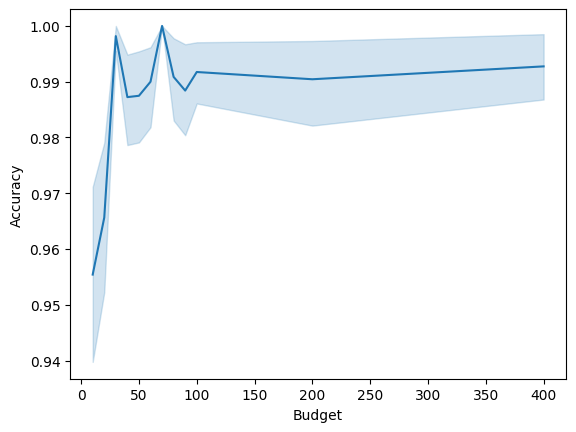

In [ ]:
import seaborn as sns

sns.lineplot(
    data=hyperopt_results_df,
    x='Budget',
    y='Accuracy'
)

<Axes: xlabel='Test', ylabel='Accuracy'>

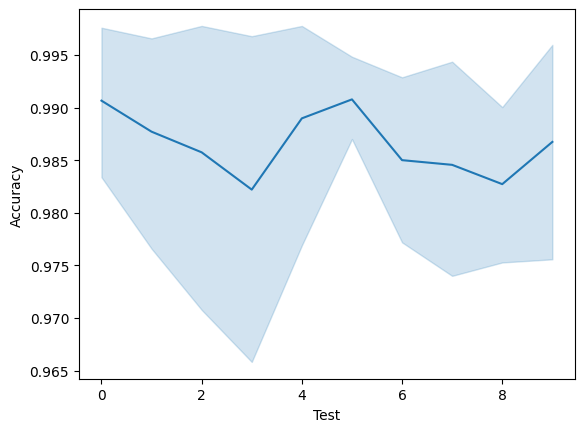

In [ ]:
import seaborn as sns

sns.lineplot(
    data=hyperopt_results_df,
    x='Test',
    y='Accuracy',
    #hue='Budget'
)

## **Statistical test to determine if the baseline models were beaten**

#### Hypotheses

We are comparing the accuracy results of the proposed hyperopt-based pipeline against the best accuracy of the baseline models. The hypotheses are defined as follows:

- **Null Hypothesis (H₀)**: The best accuracy of the baseline models (BBMA) is greater than or equal to the accuracy of the proposed hyperopt-based pipeline (PHBPA).

  $$ H_0: \mu_{\text{BBMA}} \geq \mu_{\text{PHBPA}} $$

- **Alternative Hypothesis (H₁)**: The accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).

  $$ H_1: \mu_{\text{PHBPA}} > \mu_{\text{BBMA}} $$

  ---

Working with Budget: 90

In [ ]:
# Tests for proposed hyperopt pipeline
number_of_tests = 10
hyperopt_accuracies = []
# Define the different budgets to test
budgets = [90]
hyperopt_results_df = pd.DataFrame(data=[], columns=['Test', 'Budget', 'Accuracy'])

for tn in range(number_of_tests):
    print(f"Test {tn + 1}:")
    rdf, avrg_accuracy = test_hyperopt_with_budget(budgets, tn)
    hyperopt_accuracies.append(avrg_accuracy)
    hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])

print("")
print("=" * 80)
print("=========== Final Results of Hyperopts tests =============")
print(hyperopt_results_df.to_string())
print("=" * 80)

Test 1:
100%|██████████| 90/90 [01:07<00:00,  1.33trial/s, best loss: -0.9804584304584305]
Best hyperparameters: {'max_depth': 13.0, 'max_features': 'sqrt', 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 62.0, 'rs': 0, 'ts': 0.3004421179997003}
Optimized Random Forest Accuracy: 1.0000
Test: 0, Time Budget: 90, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     0      90       1.0

=========== Final Results of Hyperopt evaluations =============
Average accuracy across different time budgets: 1.0
Test 2:
  0%|          | 0/90 [00:00<?, ?trial/s, best loss=?]

<ipython-input-63-c13d69629701>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])


100%|██████████| 90/90 [01:13<00:00,  1.23trial/s, best loss: -0.97437530622244]
Best hyperparameters: {'max_depth': 13.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 76.0, 'rs': 2, 'ts': 0.23724480612473875}
Optimized Random Forest Accuracy: 0.9713
Test: 1, Time Budget: 90, Accuracy: 0.9713

Results across different time budgets:
   Test  Budget  Accuracy
0     1      90  0.971311

=========== Final Results of Hyperopt evaluations =============
Average accuracy across different time budgets: 0.9713114754098361
Test 3:
100%|██████████| 90/90 [00:59<00:00,  1.51trial/s, best loss: -0.9649635036496349]
Best hyperparameters: {'max_depth': 17.0, 'max_features': 1, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 84.0, 'rs': 0, 'ts': 0.3315740831515642}
Optimized Random Forest Accuracy: 1.0000
Test: 2, Time Budget: 90, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     2      90       1.0

====

In [ ]:
print(hyperopt_accuracies)
print(best_baseline_accuracies)

[1.0, 0.9713114754098361, 1.0, 1.0, 1.0, 0.9699570815450643, 1.0, 1.0, 0.9595141700404858, 1.0]
[0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 1.0, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366]


In [ ]:
from scipy import stats
from scipy.stats import ttest_ind

# Perform one-sided t-test (engineer salaries > analyst salaries)
print(hyperopt_accuracies)
t_stat, p_value = ttest_ind(hyperopt_accuracies, best_baseline_accuracies, alternative='greater', equal_var=True)

# Print the p-value
print(f"P-value: {p_value}")

# Check the result at the 5% significance level (95% confidence)
if p_value < 0.05:
    print("Reject the null hypothesis: There is significant evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).")
else:
    print("Fail to reject the null hypothesis: There is no sufficient evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).")


[1.0, 0.9713114754098361, 1.0, 1.0, 1.0, 0.9699570815450643, 1.0, 1.0, 0.9595141700404858, 1.0]
P-value: 0.27550745558998313
Fail to reject the null hypothesis: There is no sufficient evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).


Working with Budget: 70

In [ ]:
# Tests for proposed hyperopt pipeline
number_of_tests = 10
hyperopt_accuracies = []
# Define the different budgets to test
budgets = [70]
hyperopt_results_df = pd.DataFrame(data=[], columns=['Test', 'Budget', 'Accuracy'])

for tn in range(number_of_tests):
    print(f"Test {tn + 1}:")
    rdf, avrg_accuracy = test_hyperopt_with_budget(budgets, tn)
    hyperopt_accuracies.append(avrg_accuracy)
    hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])

print("")
print("=" * 80)
print("=========== Final Results of Hyperopts tests =============")
print(hyperopt_results_df.to_string())
print("=" * 80)

Test 1:
100%|██████████| 70/70 [00:38<00:00,  1.82trial/s, best loss: -0.9769902555616842]
Best hyperparameters: {'max_depth': 15.0, 'max_features': 'sqrt', 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 43.0, 'rs': 0, 'ts': 0.2783171446592026}
Optimized Random Forest Accuracy: 1.0000
Test: 0, Time Budget: 70, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     0      70       1.0

=========== Final Results of Hyperopt evaluations =============
Average accuracy across different time budgets: 1.0
Test 2:
  0%|          | 0/70 [00:00<?, ?trial/s, best loss=?]

<ipython-input-74-faeb32912003>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])


100%|██████████| 70/70 [00:47<00:00,  1.48trial/s, best loss: -0.9759732505373776]
Best hyperparameters: {'max_depth': 10.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0, 'n_estimators': 61.0, 'rs': 0, 'ts': 0.227754829605439}
Optimized Random Forest Accuracy: 1.0000
Test: 1, Time Budget: 70, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     1      70       1.0

=========== Final Results of Hyperopt evaluations =============
Average accuracy across different time budgets: 1.0
Test 3:
100%|██████████| 70/70 [01:00<00:00,  1.15trial/s, best loss: -0.9719138111626515]
Best hyperparameters: {'max_depth': 11.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 8.0, 'n_estimators': 85.0, 'rs': 0, 'ts': 0.20054771023648504}
Optimized Random Forest Accuracy: 1.0000
Test: 2, Time Budget: 70, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     2      70       1.0

=========== Final 

In [ ]:
print(hyperopt_accuracies)
print(best_baseline_accuracies)

[1.0, 1.0, 1.0, 1.0, 0.9739776951672863, 1.0, 1.0, 0.990990990990991, 0.993006993006993, 1.0]
[0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 1.0, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366]


In [ ]:
from scipy import stats
from scipy.stats import ttest_ind

# Perform one-sided t-test (engineer salaries > analyst salaries)
print(hyperopt_accuracies)
t_stat, p_value = ttest_ind(hyperopt_accuracies, best_baseline_accuracies, alternative='greater', equal_var=True)

# Print the p-value
print(f"P-value: {p_value}")

# Check the result at the 5% significance level (95% confidence)
if p_value < 0.05:
    print("Reject the null hypothesis: There is significant evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).")
else:
    print("Fail to reject the null hypothesis: There is no sufficient evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).")


[1.0, 1.0, 1.0, 1.0, 0.9739776951672863, 1.0, 1.0, 0.990990990990991, 0.993006993006993, 1.0]
P-value: 0.004145559780835084
Reject the null hypothesis: There is significant evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).


Working with Budget: 400

In [ ]:
# Tests for proposed hyperopt pipeline
number_of_tests = 10
hyperopt_accuracies = []
# Define the different budgets to test
budgets = [400]
hyperopt_results_df = pd.DataFrame(data=[], columns=['Test', 'Budget', 'Accuracy'])

for tn in range(number_of_tests):
    print(f"Test {tn + 1}:")
    rdf, avrg_accuracy = test_hyperopt_with_budget(budgets, tn)
    hyperopt_accuracies.append(avrg_accuracy)
    hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])

print("")
print("=" * 80)
print("=========== Final Results of Hyperopts tests =============")
print(hyperopt_results_df.to_string())
print("=" * 80)

Test 1:
100%|██████████| 400/400 [04:05<00:00,  1.63trial/s, best loss: -0.9840640430944188]
Best hyperparameters: {'max_depth': 14.0, 'max_features': 'sqrt', 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 54.0, 'rs': 2, 'ts': 0.20311869272678176}
Optimized Random Forest Accuracy: 1.0000
Test: 0, Time Budget: 400, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     0     400       1.0

=========== Final Results of Hyperopt evaluations =============
Average accuracy across different time budgets: 1.0
Test 2:
  0%|          | 0/400 [00:00<?, ?trial/s, best loss=?]

<ipython-input-70-217e8ec6c8d8>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hyperopt_results_df = pd.concat([hyperopt_results_df, rdf])


100%|██████████| 400/400 [04:00<00:00,  1.66trial/s, best loss: -0.9837655279503107]
Best hyperparameters: {'max_depth': 14.0, 'max_features': 'sqrt', 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 39.0, 'rs': 2, 'ts': 0.2152361395866879}
Optimized Random Forest Accuracy: 0.9864
Test: 1, Time Budget: 400, Accuracy: 0.9864

Results across different time budgets:
   Test  Budget  Accuracy
0     1     400  0.986425

=========== Final Results of Hyperopt evaluations =============
Average accuracy across different time budgets: 0.9864253393665159
Test 3:
100%|██████████| 400/400 [05:00<00:00,  1.33trial/s, best loss: -0.9865030674846625]
Best hyperparameters: {'max_depth': 14.0, 'max_features': 'sqrt', 'min_samples_leaf': 1.0, 'min_samples_split': 3.0, 'n_estimators': 30.0, 'rs': 0, 'ts': 0.20484633311427994}
Optimized Random Forest Accuracy: 1.0000
Test: 2, Time Budget: 400, Accuracy: 1.0000

Results across different time budgets:
   Test  Budget  Accuracy
0     2     4

In [ ]:
print(hyperopt_accuracies)
print(best_baseline_accuracies)

[1.0, 0.9864253393665159, 1.0, 0.9903846153846154, 1.0, 1.0, 1.0, 0.9849624060150376, 0.9852941176470589, 1.0]
[0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 1.0, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366, 0.9853658536585366]


In [ ]:
from scipy import stats
from scipy.stats import ttest_ind

# Perform one-sided t-test (engineer salaries > analyst salaries)
print(hyperopt_accuracies)
t_stat, p_value = ttest_ind(hyperopt_accuracies, best_baseline_accuracies, alternative='greater', equal_var=True)

# Print the p-value
print(f"P-value: {p_value}")

# Check the result at the 5% significance level (95% confidence)
if p_value < 0.05:
    print("Reject the null hypothesis: There is significant evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).")
else:
    print("Fail to reject the null hypothesis: There is no sufficient evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).")


[1.0, 0.9864253393665159, 1.0, 0.9903846153846154, 1.0, 1.0, 1.0, 0.9849624060150376, 0.9852941176470589, 1.0]
P-value: 0.004070975201019529
Reject the null hypothesis: There is significant evidence at the 5% significance level to conclude that the accuracy of the proposed hyperopt-based pipeline (PHBPA) is greater than the best accuracy of the baseline models (BBMA).
